In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import joblib

In [2]:
df_feats = pd.read_csv("features.csv")     # handcrafted + relative paths
df_embeds = pd.read_csv("cnn_embeddings.csv")  # CNN embeddings


X_hand = df_feats.drop(columns=["relpath", "label"]).values
X_cnn = df_embeds.values
y = df_feats["label"].values

# 2️⃣ Reduce CNN embedding size with PCA
pca = PCA(n_components=50, random_state=42)
X_cnn_reduced = pca.fit_transform(X_cnn)

# 3️⃣ Merge features
X = np.hstack([X_hand, X_cnn_reduced]).astype(np.float32)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 4: Feature scaling (optional but recommended for some models)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

In [4]:
pos_weight = (y_resampled == 0).sum() / (y_resampled == 1).sum()


# Train XGBoost Classifier
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 10),
        'scale_pos_weight': pos_weight,
        'tree_method': 'hist',
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42,
    }
    clf = XGBClassifier(**params)
    scores = cross_val_score(
        clf, X_resampled, y_resampled,
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1
    )
    return scores.mean()

# 3️⃣ Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # adjust n_trials as needed

# 4️⃣ Train best model and evaluate on test set
best_params = study.best_params
best_clf = XGBClassifier(**best_params)
best_clf.fit(X_resampled, y_resampled)
y_pred = best_clf.predict(X_test_scaled)

print("✅ Best hyperparameters:", best_params)

[I 2025-07-07 18:04:03,487] A new study created in memory with name: no-name-a4f4addb-c811-4a15-9077-7fca90adf19d
[I 2025-07-07 18:04:23,954] Trial 0 finished with value: 0.9258774779203905 and parameters: {'max_depth': 4, 'learning_rate': 0.024036964280347663, 'subsample': 0.5605877071723862, 'colsample_bytree': 0.8470411903045667, 'gamma': 0.17461012492656308, 'reg_alpha': 0.8455483897719381, 'reg_lambda': 1.6606008976571698}. Best is trial 0 with value: 0.9258774779203905.
[I 2025-07-07 18:04:27,457] Trial 1 finished with value: 0.9278440117289696 and parameters: {'max_depth': 6, 'learning_rate': 0.021292159844141994, 'subsample': 0.9474741272937769, 'colsample_bytree': 0.8691613874476853, 'gamma': 0.12033788798958445, 'reg_alpha': 0.9638240591884644, 'reg_lambda': 1.5494798688637588}. Best is trial 1 with value: 0.9278440117289696.
[I 2025-07-07 18:04:31,220] Trial 2 finished with value: 0.9347678495133414 and parameters: {'max_depth': 8, 'learning_rate': 0.02616852178122111, 'subs

✅ Best hyperparameters: {'max_depth': 7, 'learning_rate': 0.12431321726210519, 'subsample': 0.5584401559373892, 'colsample_bytree': 0.9324235557445519, 'gamma': 0.09204713730776512, 'reg_alpha': 0.08747601783034795, 'reg_lambda': 3.9319578342596}


In [5]:
print("✅ Model Evaluation Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

✅ Model Evaluation Results:
Accuracy: 0.9556650246305419

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94        77
           1       0.96      0.97      0.96       126

    accuracy                           0.96       203
   macro avg       0.95      0.95      0.95       203
weighted avg       0.96      0.96      0.96       203



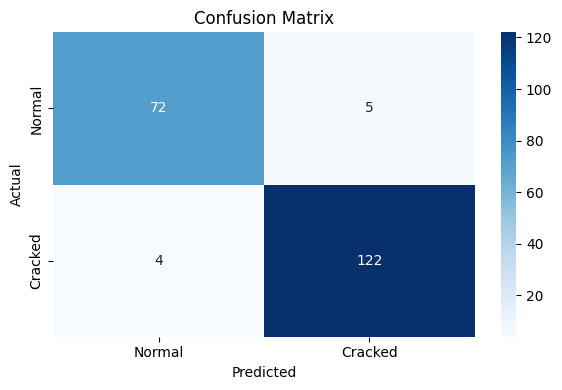

In [6]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Cracked"], yticklabels=["Normal", "Cracked"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [7]:
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pca, "pca.pkl")
joblib.dump(best_clf, "xgb_model.pkl")

['xgb_model.pkl']